In [1]:
import os
import numpy as np
import matplotlib
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
import phate
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt
os.chdir('../src/')
import data_loader
import mappings


In [2]:
PROJECT_PATH = '/home/mila/s/shuang.ni/phate_genetics/shuang/'
SCRATCH_PATH = '/home/mila/s/shuang.ni/scratch/phate_genetics/'
DATA_PATH = SCRATCH_PATH + '1KGP/'
SAVE_PATH = SCRATCH_PATH + 'results/'
Figure_PATH = PROJECT_PATH + 'figures/'

In [3]:
fname = '1000G.2504_WGS30x.GSA17k_MHI.intersectGSA.miss10perc.maf0.05.pruned.autosomes.noHLA.phased_imputed_V1.hdf5'

In [4]:
inputs, class_labels, samples, snp_names, class_label_names = data_loader.load_data_1000G(os.path.join(DATA_PATH, fname))
label_with_names, label_with_superpop_names = data_loader.preprocess_labels_1000G(class_labels, class_label_names)

In [5]:
pca_obj = sklearn.decomposition.PCA(n_components=100, random_state=42)
pca_input = pca_obj.fit_transform(inputs)

## or load from saved PCA

In [6]:
def load_from_local(fpath):
    # Load into a DataFrame
    df = pd.read_csv(fpath)
    df.set_index('Unnamed: 0', inplace=True)
    return df    

# inputs = load_from_local('../data/1000G/1000G_PCA')
# labels = load_from_local('../data/1000G/1000G_labels')
admix_ratios = load_from_local('../data/1000G/1000G_admix_ratios')

# define confusion_matrix maker

In [7]:
def make_confusion_matrix(clusterer, ax, colorbar=True):
    df = pd.DataFrame(columns=['HDBSCAN Cluster', 'Population'])
    df['HDBSCAN Cluster'] = clusterer.labels_
    df['Population'] = label_with_names

    # Filter out the -1 cluster (unclustered data)
    df = df[df['HDBSCAN Cluster'] != -1]
    # Create a cross-tabulation of clusters and populations
    crosstab = pd.crosstab(df['HDBSCAN Cluster'], df['Population'])
    # Convert counts to proportions
    proportions = crosstab.div(crosstab.sum(axis=1), axis=0)

    # Reorder the populations to match the clusters
    ordered_populations = proportions.idxmax().sort_values().index
    proportions = proportions[ordered_populations]


    heatmap = sns.heatmap(proportions, cmap='viridis', annot=False,linewidths=0.05, linecolor='purple', 
                            cbar=colorbar if colorbar else None, cbar_kws={'shrink': 0.8} if colorbar else None, ax=ax)
    heatmap.invert_yaxis()
    ax.set_xlabel('Population')
    ax.set_ylabel('HDBSCAN Cluster')
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=14)
    heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=12)

    # Adjust the color bar tick labels font size
    if colorbar:
        cbar = heatmap.collections[0].colorbar
        cbar.ax.tick_params(labelsize=12)
    return heatmap

# PHATE

In [17]:
# initial phate embedding
phate_operator_10d = phate.PHATE(random_state=42, 
                                n_components=10, 
                                knn=6, 
                                t=6, 
                                decay=60,
                                n_pca=None)
phate_operator_10d.fit(pca_input)
phate_emb_10d = phate_operator_10d.transform()

Running PHATE on 2322 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.47 seconds.
  Calculating affinities...
  Calculated affinities in 0.03 seconds.
Calculated graph and diffusion operator in 0.51 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.15 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.27 seconds.
Calculated landmark operator in 2.07 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.23 seconds.
Calculating metric MDS...


/home/mila/s/shuang.ni/.conda/envs/genetics/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Calculated metric MDS in 102.71 seconds.


In [28]:
# hdbscan parameters
min_cluster_size = 60 # 25
min_samples = 1
eps = 3.5
metric='euclidean'
alpha = 1.5
cluster_selection_method='leaf'

In [29]:
# use hdbscan package
clusterer_phate = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                            min_samples=min_samples, 
                            # alpha = alpha, # doesn't matter
                            # cluster_selection_epsilon=eps, 
                            # metric = metric, 
                            cluster_selection_method = cluster_selection_method
)
cluster_labels = clusterer_phate.fit(phate_emb_10d)
print('Number of clusters:', str(max(clusterer_phate.labels_)))
print('Number unassigned:', str(np.sum(clusterer_phate.labels_ == -1)))
cluster_label, counts = np.unique(clusterer_phate.labels_, return_counts=True)
print(f'Cluster counts: {counts}')

Number of clusters: 18
Number unassigned: 155
Cluster counts: [155 103 104  64  99  67  93  71  99 364  88 110 107  96 184  82 153  97
  88  98]


In [190]:
# OR use sklearn
clusterer = sklearn.cluster.HDBSCAN(min_cluster_size=min_cluster_size, cluster_selection_epsilon=eps)
clusterer.fit(phate_emb_10d)

HDBSCAN(min_cluster_size=20)

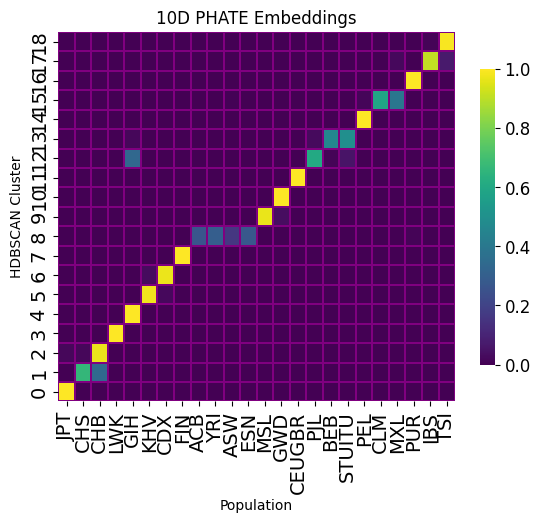

In [30]:
fig, ax = plt.subplots()
make_confusion_matrix(clusterer_phate, ax=ax)
ax.set_title('10D PHATE Embeddings')
plt.show()

# UMAP

In [8]:
import umap
umap_op = umap.UMAP(n_components=10, random_state=42)
umap_embedding = umap_op.fit_transform(pca_input)

/home/mila/s/shuang.ni/.conda/envs/genetics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mila/s/shuang.ni/.conda/envs/genetics/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [9]:
# hdbscan parameters
min_cluster_size = 60 # 25
min_samples = 1
eps = 1.5
metric='euclidean'
alpha = 1.5
cluster_selection_method='leaf'

In [10]:
# use hdbscan package
clusterer_umap = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                            min_samples=min_samples, 
                            # alpha = alpha, # doesn't matter
                            # cluster_selection_epsilon=eps, 
                            metric = metric, 
                            cluster_selection_method = cluster_selection_method
)
cluster_labels = clusterer_umap.fit(umap_embedding)
print('Number of clusters:', str(max(clusterer_umap.labels_)))
print('Number unassigned:', str(np.sum(clusterer_umap.labels_ == -1)))
cluster_label, counts = np.unique(clusterer_umap.labels_, return_counts=True)
print(f'Cluster counts: {counts}')

Number of clusters: 21
Number unassigned: 151
Cluster counts: [151  99  76 103  99 112  85 107  82  98  93  90  88  65  75 129  89 108
 104  68  88 114 199]


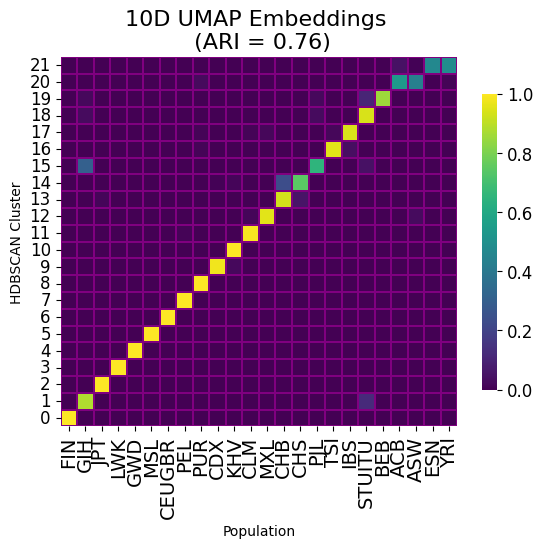

In [11]:
fig, ax = plt.subplots()
make_confusion_matrix(clusterer_umap, ax=ax)
ax.set_title('10D UMAP Embeddings \n (ARI = 0.76)', fontsize=16)
plt.show()

# t-SNE

In [92]:
tsne_op = TSNE(n_components=10, perplexity=20, n_iter=1000, method='exact',random_state=42) # , method='exact'
tsne_embedding = tsne_op.fit_transform(pca_input)

In [102]:
# hdbscan parameters
min_cluster_size = 60 # 25
min_samples = 1
eps = 0.5
metric='euclidean'
alpha = 1.0
cluster_selection_method='leaf'

In [112]:
# use hdbscan package
clusterer_tsne = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                            min_samples=min_samples, 
                            # alpha = alpha,
                            # cluster_selection_epsilon=eps, 
                            # metric = metric
                            )
clusterer_tsne.fit(tsne_embedding)
print('Number of clusters:', str(max(clusterer_tsne.labels_)))
print('Number unassigned:', str(np.sum(clusterer_tsne.labels_ == -1)))

Number of clusters: 7
Number unassigned: 47


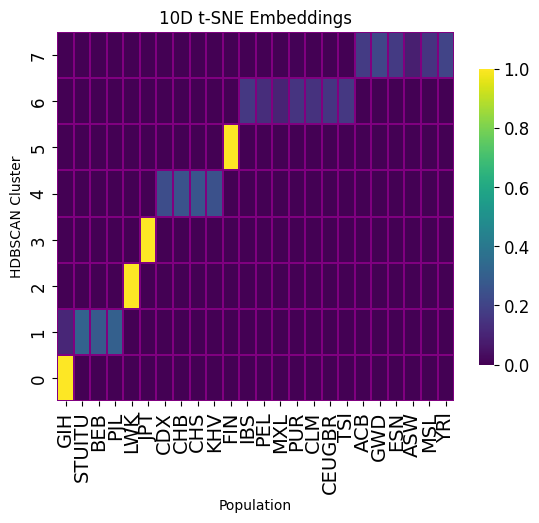

In [113]:
fig, ax = plt.subplots()
make_confusion_matrix(clusterer_tsne, ax=ax)
ax.set_title('10D t-SNE Embeddings')
plt.show()

# PCA

In [21]:
pca_obj = sklearn.decomposition.PCA(n_components=10, random_state=42)
pca_embedding = pca_obj.fit_transform(pca_input)

In [83]:
# hdbscan parameters
min_cluster_size = 60 # 25
min_samples = 1
eps = 3.5
metric='euclidean'
alpha = 1.5
cluster_selection_method='leaf'

In [107]:
# use hdbscan package
clusterer_pca = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                            min_samples=min_samples, 
                            # alpha = alpha, # doesn't matter
                            # cluster_selection_epsilon=eps, 
                            # metric = metric, 
                            cluster_selection_method = cluster_selection_method
)
cluster_labels = clusterer_pca.fit(pca_embedding)
print('Number of clusters:', str(max(clusterer_pca.labels_)))
print('Number unassigned:', str(np.sum(clusterer_pca.labels_ == -1)))
cluster_label, counts = np.unique(clusterer_pca.labels_, return_counts=True)
print(f'Cluster counts: {counts}')

Number of clusters: 18
Number unassigned: 271
Cluster counts: [271 103  67  99 147  62  78 192  99 111  86 107 219 117  63  72  64  85
 215  65]


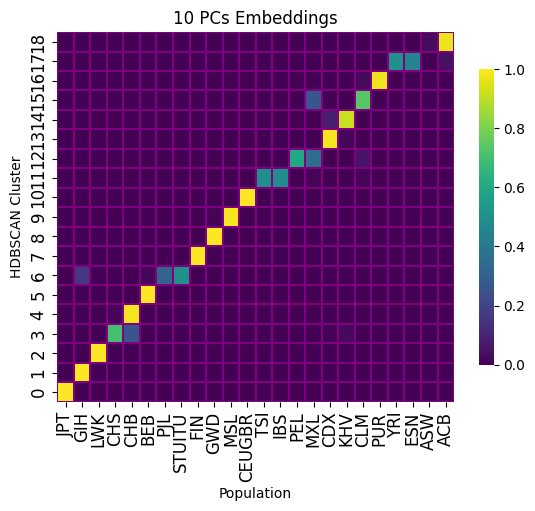

In [109]:
fig, ax = plt.subplots()
make_confusion_matrix(clusterer_pca, ax=ax)
ax.set_title('10 PCs Embeddings')
plt.show()

# all

In [86]:
# hdbscan parameters
min_cluster_size = 60 # 25
min_samples = 1
eps = 1.5
metric='euclidean'
alpha = 1.5
cluster_selection_method='leaf'

In [123]:
def get_summary(clusterer):
    print('Number of clusters:', str(max(clusterer.labels_)+1))
    print('Number unassigned:', str(np.sum(clusterer.labels_ == -1)))
    cluster_label, counts = np.unique(clusterer.labels_, return_counts=True)
    print(f'Cluster counts: {counts}')
    print('ARI:', adjusted_rand_score(label_with_names, clusterer.labels_))
    


print('PHATE')
clusterer_phate = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, 
                                #   cluster_selection_epsilon = eps, 
                                   metric = metric,
                                  cluster_selection_method = cluster_selection_method
                                  )
clusterer_phate.fit(phate_emb_10d)
get_summary(clusterer_phate)

# t-SNE
print('t-SNE')
clusterer_umap = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, 
                                #  cluster_selection_epsilon = eps, 
                                 metric = metric,
                                 cluster_selection_method = cluster_selection_method
                                 )
clusterer_umap.fit(tsne_embedding)
get_summary(clusterer_tsne)

# UMAP
print('UMAP')
clusterer_umap = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, 
                                #  cluster_selection_epsilon = eps, 
                                 metric = metric,
                                 cluster_selection_method = cluster_selection_method
                                 )
clusterer_umap.fit(umap_embedding)
get_summary(clusterer_umap)


# PCA
print('PCA')
clusterer_pca = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, 
                                # cluster_selection_epsilon = eps, 
                                 metric = metric,
                                cluster_selection_method = cluster_selection_method
                                )
clusterer_pca.fit(pca_embedding)
get_summary(clusterer_pca)

# PCA
print('PCA 100D')
clusterer_pca_full = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, 
                                    #  cluster_selection_epsilon = eps, 
                                     metric = metric,
                                     cluster_selection_method = cluster_selection_method
                                     )
clusterer_pca_full.fit(pca_input)
get_summary(clusterer_pca_full)

PHATE
Number of clusters: 19
Number unassigned: 155
Cluster counts: [155 103 104  64  99  67  93  71  99 364  88 110 107  96 184  82 153  97
  88  98]
ARI: 0.6333594889897748
t-SNE
Number of clusters: 8
Number unassigned: 47
Cluster counts: [ 47  67 309  97 103 401  99 663 536]
ARI: 0.29443825707915755
UMAP
Number of clusters: 22
Number unassigned: 149
Cluster counts: [149  99  76 103  99 112  85  82 107  98  90  89  88  65  90 105 111  77
 114  81  86 194 122]
ARI: 0.7589373580748764
PCA
Number of clusters: 19
Number unassigned: 271
Cluster counts: [271 103  67  99 147  62  78 192  99 111  86 107 219 117  63  72  64  85
 215  65]
ARI: 0.6210063512995372
PCA 100D
Number of clusters: 11
Number unassigned: 633
Cluster counts: [633 393 101 206  64  85 136 198  65  69 280  92]
ARI: 0.31695115645352984


/tmp/ipykernel_1672188/2031164688.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.78, 1])  # Adjust layout to make space for the colorbar


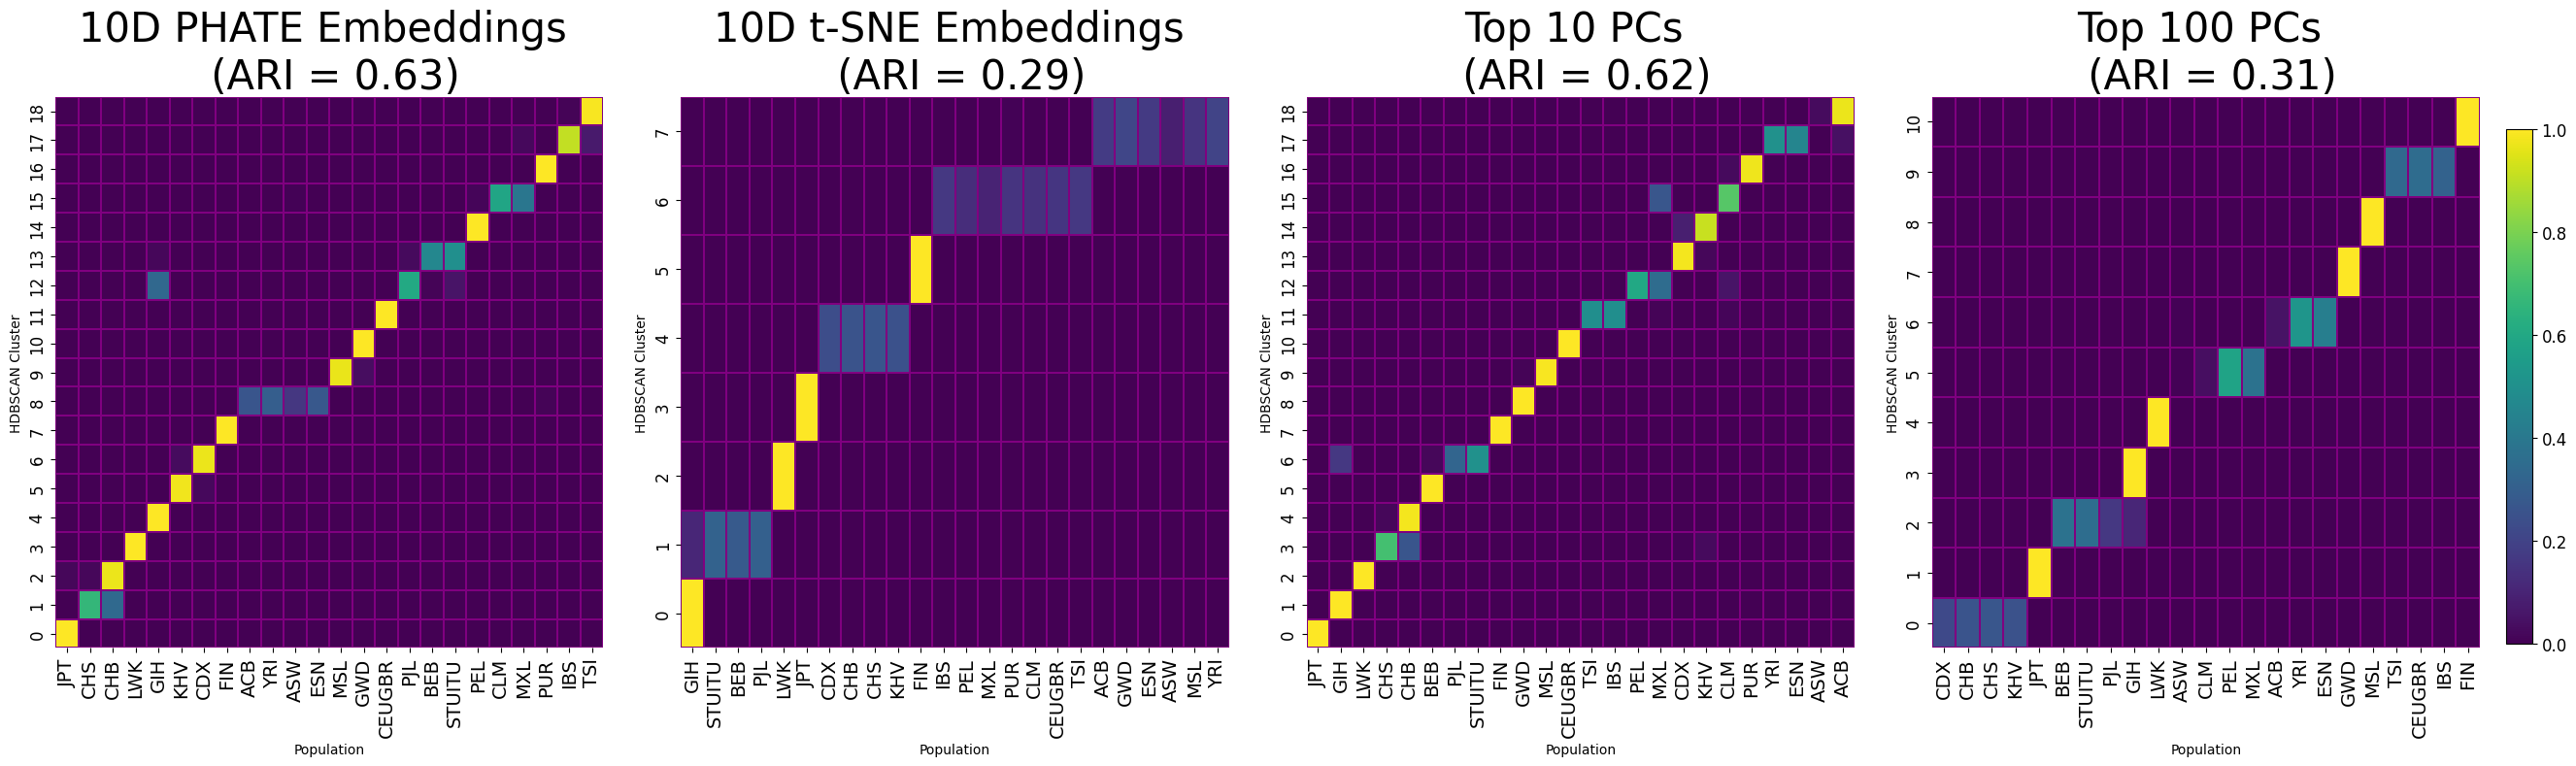

In [125]:
fig, ax = plt.subplots(ncols=4, figsize=(33, 8))
make_confusion_matrix(clusterer_phate, ax=ax[0], colorbar=False)
make_confusion_matrix(clusterer_tsne, ax=ax[1], colorbar=False)
# make_confusion_matrix(clusterer_umap, ax=ax[2], colorbar=False)
make_confusion_matrix(clusterer_pca, ax=ax[2], colorbar=False)
heatmap4 = make_confusion_matrix(clusterer_pca_full, ax=ax[3], colorbar=False)

_ = ax[0].set_title('10D PHATE Embeddings \n (ARI = 0.63)', size=30)
_ = ax[1].set_title('10D t-SNE Embeddings \n (ARI = 0.29)', size=30)
# _ = ax[2].set_title('10D UMAP Embeddings \n (ARI = 0.76)', size=30)
_ = ax[2].set_title('Top 10 PCs \n (ARI = 0.62)', size=30)
_ = ax[3].set_title('Top 100 PCs \n (ARI = 0.31)', size=30)
# plt.tight_layout()

# Create a single colorbar for all subplots
cbar = fig.colorbar(heatmap4.collections[0], ax=ax, location='right', shrink=0.86, aspect=20, pad=0.01)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout(rect=[0, 0, 0.78, 1])  # Adjust layout to make space for the colorbar
plt.show()